In [120]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import scipy
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import clone

In [ ]:
# import gdown
# import os

# def load(id, filename):
#   if not os.path.isfile(filename):
#     gdown.download(id=id, output=filename)

# load('1yfHdlXnGE-xyjEG8h0NttjAKWVM_Z3_4', 'sample_submission.csv')
# load('1nCfX_ZFl3RfShc0_DwK8SA7w8o1hN2K4', 'test.csv')
# load('1ILTPJJLmWnLFdK9E_nQhxBDFsTcGDyDH', 'train.csv')

In [122]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Вспомогательные функции

### Визуализация

In [ ]:
def show_dependency(df, xcols, ycols):
  if not isinstance(xcols,(list,np.ndarray)):
    xcols = [xcols]
  if not isinstance(ycols,(list,np.ndarray)):
    ycols = [ycols]

  xcols = np.array(xcols)
  ycols = np.array(ycols)
  cnt = xcols.shape[0]
  cols = min(3, cnt)
  rows = (cnt + 2) // 3
  plt.figure(figsize=(cols * 6, rows * 5))

  for i in range(0, cnt):
    plt.subplot(rows, cols, i+1)
    xcol = xcols[i]
    ycol = ycols[i]
    corr_matrix = df[[xcol, ycol]].corr()
    x = df[xcol]
    y = df[ycol]
    p = np.poly1d(np.polyfit(x, y, 1))
    plt.scatter(x, y, alpha=0.5)
    plt.ylim(np.min(plt.yticks()[0]), np.max(plt.yticks()[0]))
    plt.plot(x, p(x), "r--")
    plt.scatter([], [], alpha=0, label=f'Корреляция: {corr_matrix[xcol][ycol]:.3f}')
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.title(f'Зависимость {ycol} от {xcol}')
    plt.grid(True)
    plt.legend()
  plt.show()

In [124]:
def show_corr_matrix(df, min_corr = 0, annot = False, dropTarget = True, fmt='.2g', figsize=(12, 6), grid=False):
  if dropTarget:
    df = df.drop(columns='RiskScore', errors='ignore')
  corr_matrix = df.corr()
  plt.figure(figsize=figsize)
  sns.heatmap(corr_matrix[corr_matrix.abs() > min_corr], cmap='coolwarm', vmin=-1, vmax=1, annot=annot, fmt=fmt)
  plt.title("Корреляционная матрица")
  plt.grid(grid)
  plt.show()

def show_corr_column(df, column, min_corr = 0, annot = False, dropTarget = True, fmt='.2g', figsize=(8, 6), grid=False):
  if dropTarget:
    df = df.drop(columns='RiskScore', errors='ignore')
  corr_column = df.corrwith(df[column]).drop(index=column)
  corr_column = corr_column[corr_column.abs() > min_corr]
  plt.figure(figsize=figsize)
  sns.heatmap(corr_column.values.reshape(-1, 1), xticklabels=[column], yticklabels=corr_column.index,
              cmap='coolwarm', vmin=-1, vmax=1, annot=annot, fmt=fmt)
  plt.title("Корреляционная матрица")
  plt.grid(grid)
  plt.show()

In [125]:
def build_distribution(values, column):
  sns.kdeplot(values, fill=True, cut=0)
  plt.plot([values.mean(), values.mean()], [0, np.max(plt.yticks()[0])], label='Средее')
  plt.scatter([], [], alpha=0, label=f'Асимметрия: {scipy.stats.skew(values):.3f}')
  plt.scatter([], [], alpha=0, label=f'Эксцесс: {scipy.stats.kurtosis(values):.3f}')
  plt.title(f'Плотность {column}')
  plt.legend()

def show_distribution(df, column):
  plt.figure(figsize=(13, 5))
  plt.subplot(1, 2, 1)
  build_distribution(df[column], column)
  plt.subplot(1, 2, 2)
  plt.boxplot(df[column], tick_labels=[column])
  plt.title(f'Размах {column}')
  plt.show()

def show_distributions(df, columns):
  cnt = len(columns)
  rows = (cnt + 1) // 2
  plt.figure(figsize=(13, 6 * rows))
  for i in range(len(columns)):
    plt.subplot(rows, 2, i + 1)
    build_distribution(df[columns[i]], columns[i])
  plt.show()

def compare_distribution(df, left_column, right_column):
  plt.figure(figsize=(13, 5))
  plt.subplot(1, 2, 1)
  build_distribution(df[left_column], left_column)
  plt.subplot(1, 2, 2)
  build_distribution(df[right_column], right_column)
  plt.show()

# Разведочный анализ данных

In [126]:
display(train_data.info())
display(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   15000 non-null  int64  
 1   age                  15000 non-null  float64
 2   height(cm)           15000 non-null  float64
 3   weight(kg)           15000 non-null  float64
 4   waist(cm)            15000 non-null  float64
 5   eyesight(left)       15000 non-null  float64
 6   eyesight(right)      15000 non-null  float64
 7   hearing(left)        15000 non-null  float64
 8   hearing(right)       15000 non-null  float64
 9   systolic             15000 non-null  float64
 10  relaxation           15000 non-null  float64
 11  fasting blood sugar  15000 non-null  float64
 12  Cholesterol          15000 non-null  float64
 13  triglyceride         15000 non-null  float64
 14  HDL                  15000 non-null  float64
 15  LDL                  15000 non-null 

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   height(cm)           10000 non-null  float64
 3   weight(kg)           10000 non-null  float64
 4   waist(cm)            10000 non-null  float64
 5   eyesight(left)       10000 non-null  float64
 6   eyesight(right)      10000 non-null  float64
 7   hearing(left)        10000 non-null  float64
 8   hearing(right)       10000 non-null  float64
 9   systolic             10000 non-null  float64
 10  relaxation           10000 non-null  float64
 11  fasting blood sugar  10000 non-null  float64
 12  Cholesterol          10000 non-null  float64
 13  triglyceride         10000 non-null  float64
 14  HDL                  10000 non-null  float64
 15  LDL                  10000 non-null  

None

In [127]:
print("TRAIN")
display(train_data.loc[:, 'id':'fasting blood sugar'].head())
display(train_data.loc[:, 'Cholesterol':'smoking'].head())
print("")
print("TEST")
display(test_data.loc[:, 'id':'fasting blood sugar'].head())
display(test_data.loc[:, 'Cholesterol':'dental caries'].head())

TRAIN


,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar
0,0,55.0,150.0,50.0,73.0,0.8,1.0,1.0,1.0,122.0,70.0,92.0
1,1,50.0,160.0,60.0,79.6,1.0,0.8,1.0,1.0,124.0,65.0,89.0
2,2,55.0,145.0,50.0,73.0,1.2,1.2,1.0,1.0,110.0,70.0,89.0
3,3,40.0,175.0,80.0,83.2,0.9,1.0,1.0,1.0,99.0,61.0,91.0
4,4,30.0,170.0,70.0,79.5,1.2,1.2,1.0,1.0,119.0,79.0,88.0


,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,184.0,49.0,62.0,113.0,12.0,1.0,0.6,22.0,21.0,12.0,0.0,0.0
1,201.0,75.0,74.0,112.0,14.1,1.0,0.9,19.0,14.0,17.0,0.0,0.0
2,203.0,72.0,66.0,123.0,13.3,1.0,0.6,15.0,12.0,13.0,0.0,0.0
3,168.0,78.0,38.0,114.0,16.1,1.0,1.0,22.0,13.0,20.0,0.0,1.0
4,215.0,87.0,49.0,148.0,15.5,1.0,1.2,18.0,19.0,25.0,0.0,1.0



TEST


,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar
0,15000,40.0,155.0,45.0,64.0,0.9,0.9,1.0,1.0,109.0,70.0,97.0
1,15001,45.0,175.0,90.0,101.0,1.0,1.2,1.0,1.0,130.0,80.0,105.0
2,15002,40.0,165.0,60.0,78.0,1.5,1.5,1.0,1.0,107.0,69.0,83.0
3,15003,35.0,170.0,60.0,84.5,1.0,1.0,1.0,1.0,124.0,80.0,112.0
4,15004,40.0,155.0,45.0,68.5,1.0,1.0,1.0,1.0,109.0,70.0,90.0


,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,196.0,50.0,79.0,108.0,13.3,1.0,0.9,16.0,11.0,17.0,0.0
1,166.0,147.0,38.0,99.0,16.2,1.0,0.9,23.0,21.0,28.0,1.0
2,214.0,60.0,67.0,136.0,14.9,1.0,0.9,30.0,36.0,16.0,0.0
3,216.0,127.0,63.0,128.0,15.4,1.0,0.8,21.0,17.0,26.0,1.0
4,205.0,47.0,61.0,133.0,11.5,1.0,0.7,22.0,12.0,17.0,0.0


In [ ]:
train_data_nunique = train_data.nunique()
test_data_nunique = test_data.nunique()
test_data_nunique['smoking'] = '-'
overall_data_nunique = pd.concat([train_data.drop(columns='smoking'), test_data]).nunique()
overall_data_nunique['smoking'] = train_data_nunique['smoking']
pd.DataFrame({'TRAIN feature cardinality': train_data_nunique,
              'TEST feature cardinality': test_data_nunique,
              'OVERALL feature cardinality': overall_data_nunique})

,TRAIN feature cardinality,TEST feature cardinality,OVERALL feature cardinality
id,15000,10000,25000
age,13,13,13
height(cm),11,10,11
weight(kg),17,15,17
waist(cm),355,334,388
eyesight(left),14,16,16
eyesight(right),14,14,14
hearing(left),2,2,2
hearing(right),2,2,2
systolic,77,76,81


Все признаки имеют тип float. Значения всех числовых признаков сгруппированы по интервалам. Бинарных признака 4: hearing(left), hearing(right) dental caries и smoking

In [129]:
test_data_na_count = test_data.isna().sum()
test_data_na_count['smoking'] = '-'
pd.DataFrame({'TRAIN NA count': train_data.isna().sum(), 'TEST NA count': test_data_na_count})

,TRAIN NA count,TEST NA count
id,0,0
age,0,0
height(cm),0,0
weight(kg),0,0
waist(cm),0,0
eyesight(left),0,0
eyesight(right),0,0
hearing(left),0,0
hearing(right),0,0
systolic,0,0


In [ ]:
pd.DataFrame(index=['test_data', 'train_data'],
             columns=['Duplicate count'],
             data=[test_data.duplicated().sum(), test_data.duplicated().sum()])

,Duplicate count
test_data,0
train_data,0


Пропусков и дубликатов нет

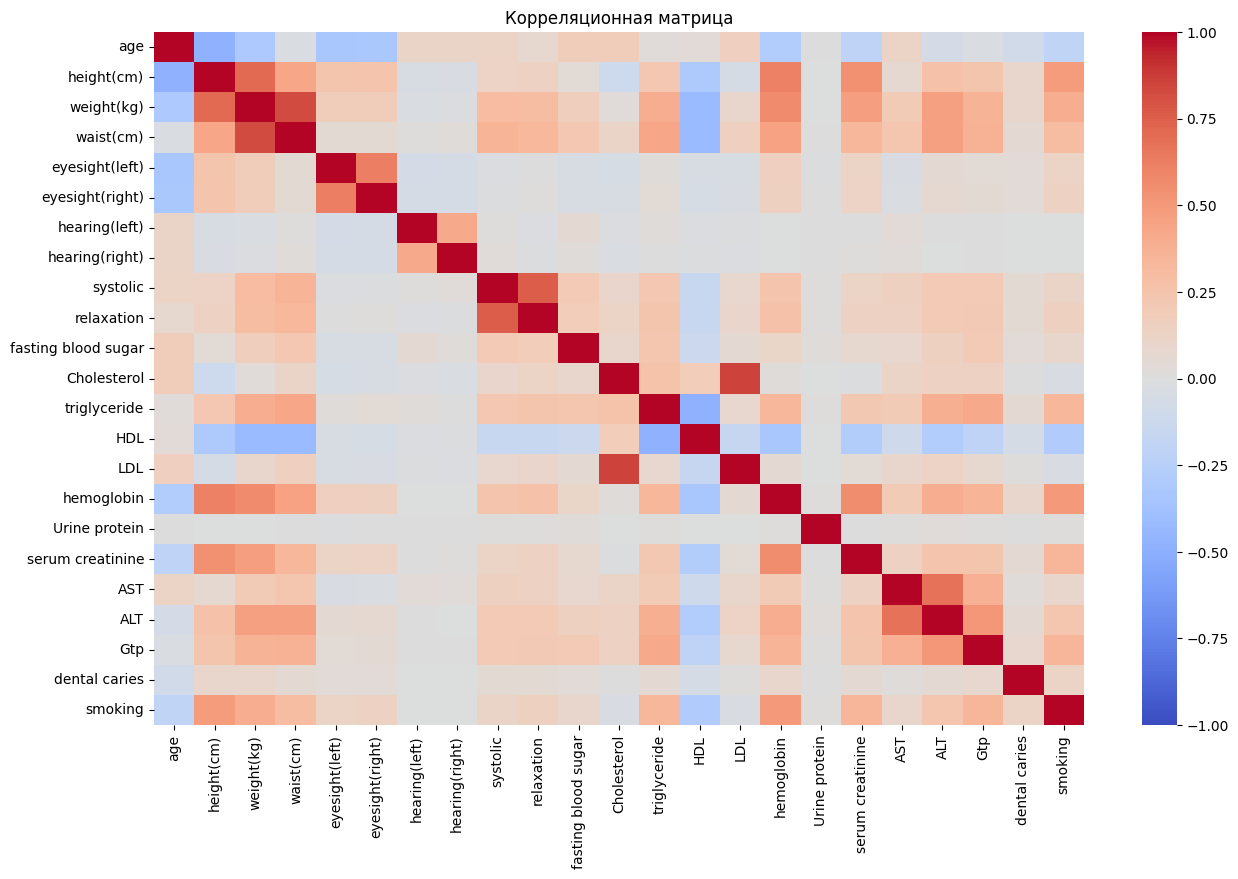

In [131]:
show_corr_matrix(train_data.drop(columns='id'), figsize=(15,9))

Примеры практического отсутствия корреляции корреляции ($|c| < 0.05$).

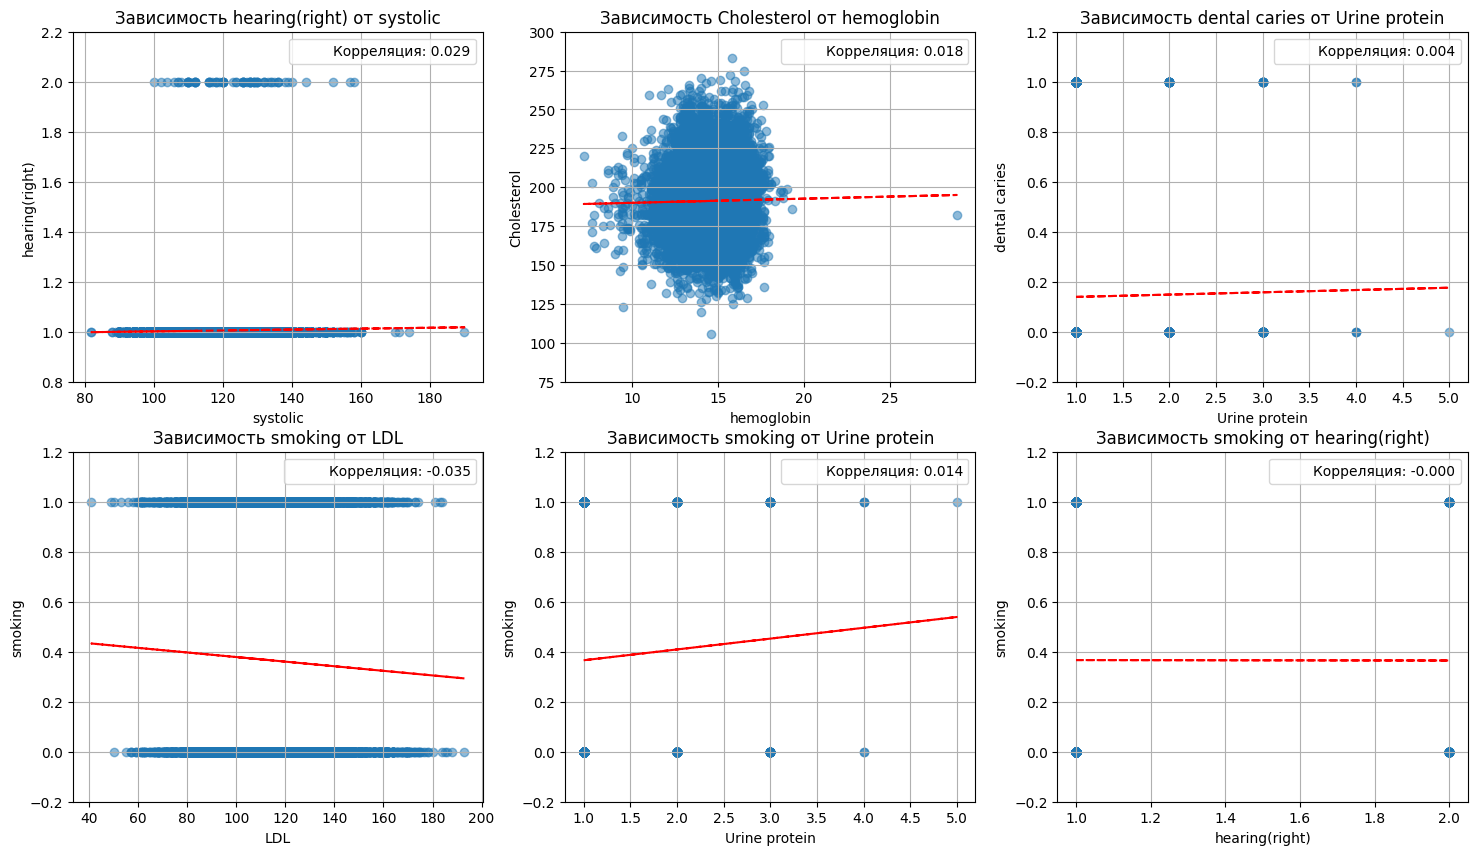

In [132]:
show_dependency(train_data,
  ['systolic', 'hemoglobin', 'Urine protein', 'LDL', 'Urine protein', 'hearing(right)'],
  ['hearing(right)', 'Cholesterol', 'dental caries', 'smoking', 'smoking', 'smoking'])

Примеры слабой корреляции ($0.05 \leq |c| < 0.3$).

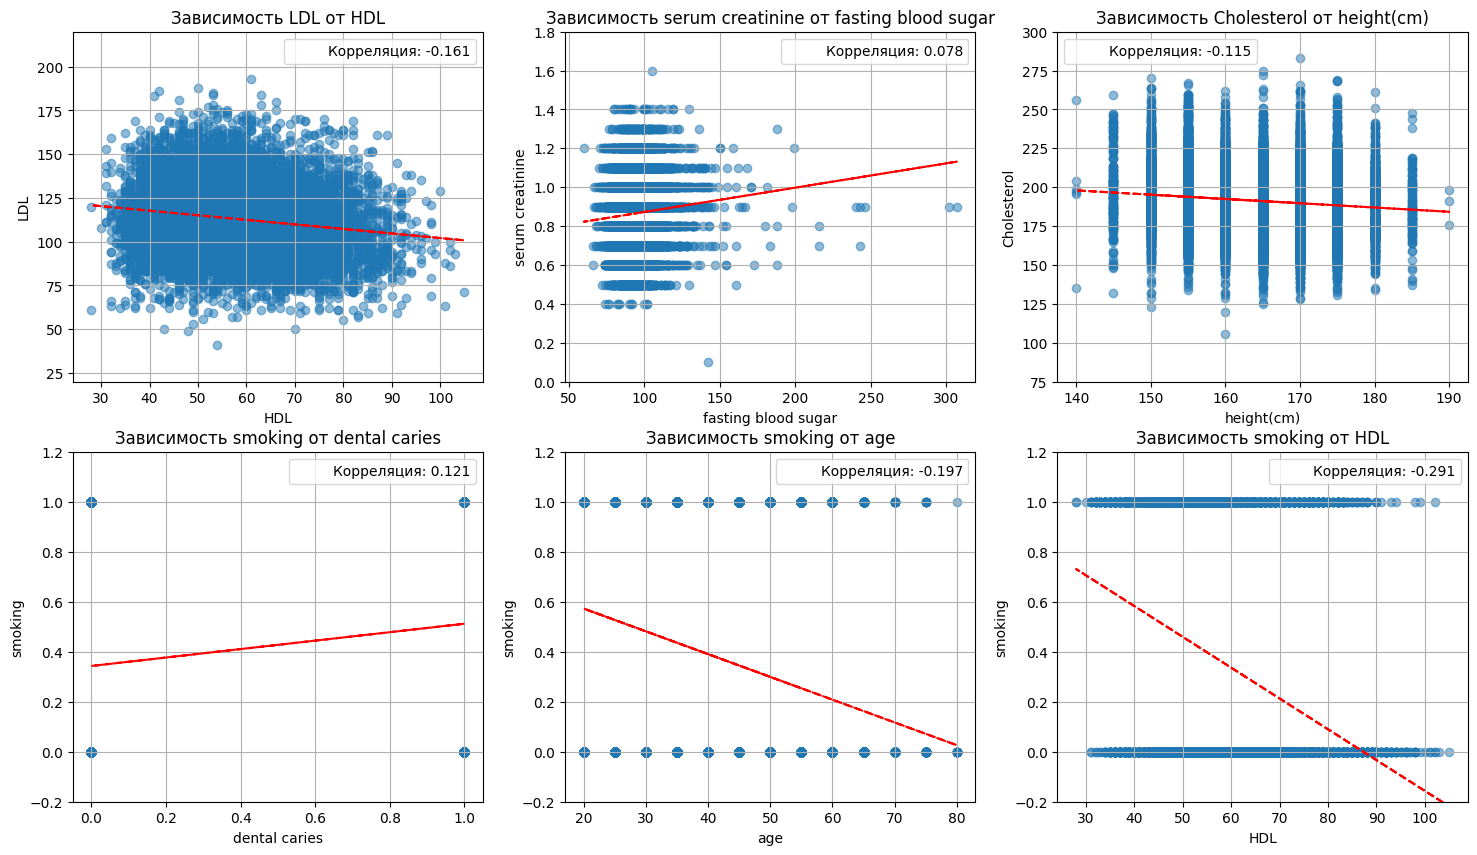

In [133]:
show_dependency(train_data,
  ['HDL', 'fasting blood sugar', 'height(cm)', 'dental caries', 'age', 'HDL'],
  ['LDL', 'serum creatinine', 'Cholesterol', 'smoking', 'smoking', 'smoking'])

Примеры средней корреляции ($0.3 \leq |c| < 0.7$).

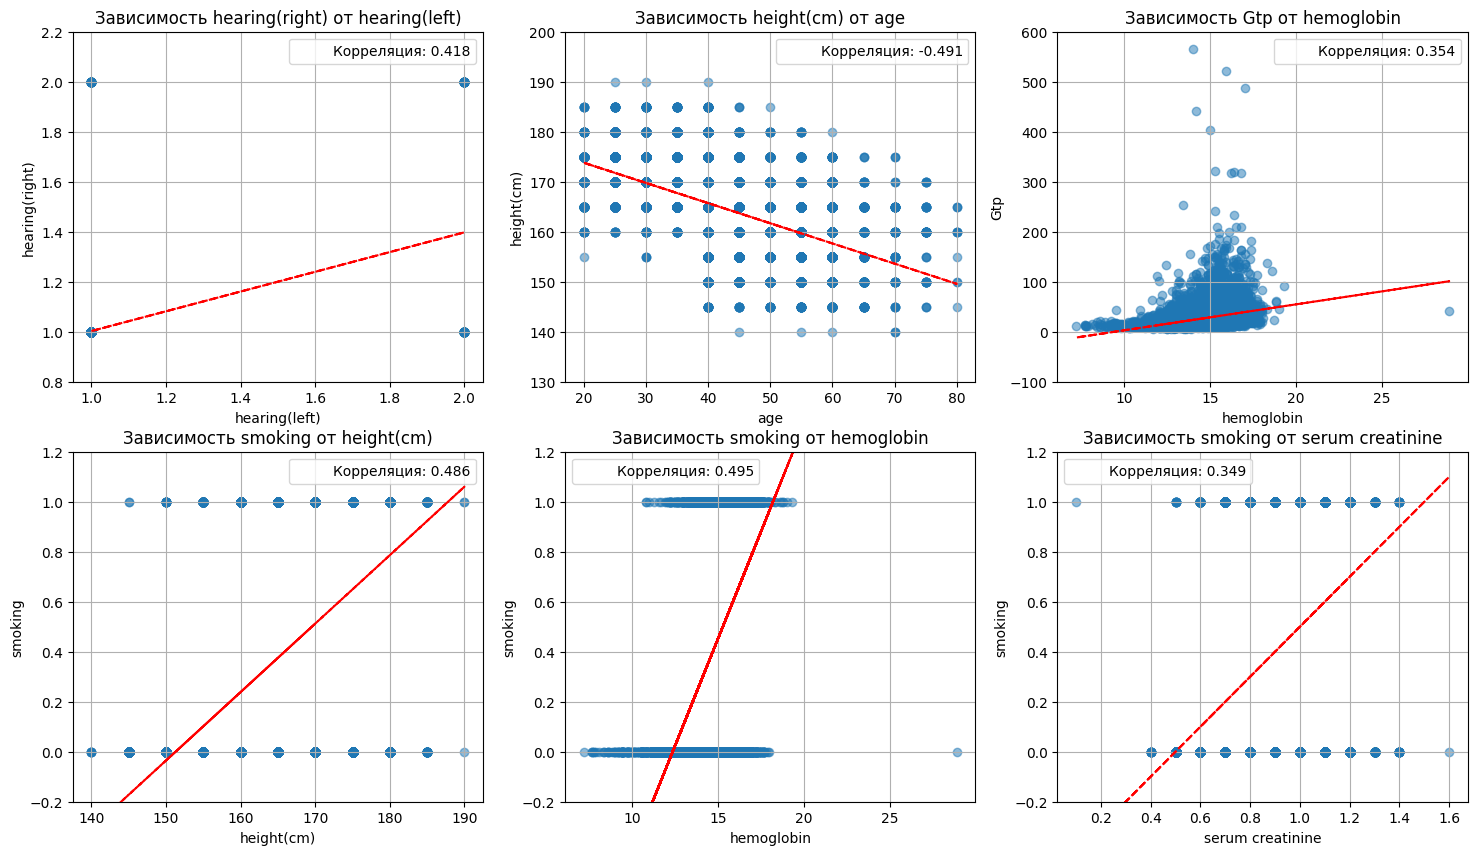

In [134]:
show_dependency(train_data,
  ['hearing(left)', 'age', 'hemoglobin', 'height(cm)', 'hemoglobin', 'serum creatinine'],
  ['hearing(right)', 'height(cm)', 'Gtp', 'smoking', 'smoking', 'smoking'])

Примеры сильной корреляции ($|c| \geq 0.7$).

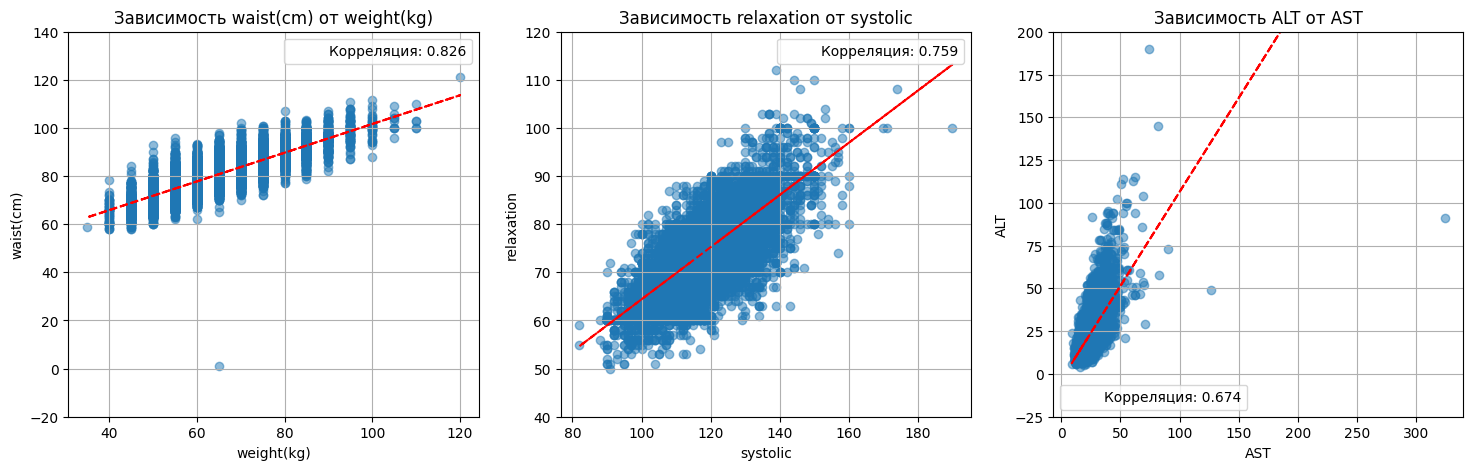

In [135]:
show_dependency(train_data,
  ['weight(kg)', 'systolic', 'AST'],
  ['waist(cm)', 'relaxation', 'ALT'])

In [136]:
train_data = train_data.drop(columns='id')

# Обработка данных

# Алгоритмы

### Метрики

In [137]:
def accuracy_score(y_true, y_pred):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  return (y_true == y_pred).sum() / y_true.shape[0]

def precision_score(y_true, y_pred):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  tp = (y_true * y_pred).sum()
  fp = ((y_true == 0) * y_pred).sum()
  if tp + fp == 0:
    return 1
  return tp / (tp + fp)

def recall_score(y_true, y_pred):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  tp = (y_true * y_pred).sum()
  fn = (y_true * (y_pred == 0)).sum()
  return tp / (tp + fn)

def f1_score(y_true, y_pred):
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  return 2 * precision * recall / (precision + recall)

def roc_auc_score(y_true, y_pred_proba):
  y_true = np.array(y_true)
  y_pred_proba = np.array(y_pred_proba)
  thresholds = (y_pred_proba[1:] + y_pred_proba[:-1]) / 2
  unique_indices = np.where(y_pred_proba[1:] != y_pred_proba[:-1])[0]

  thresholds = thresholds[unique_indices]
  thresholds = np.concat((thresholds, np.array([-float('inf'), float('inf')])));
  thresholds = np.sort(thresholds)

  fpr = np.ndarray(thresholds.shape)
  tpr = np.ndarray(thresholds.shape)

  for i in range(0, thresholds.shape[0]):
    y_pred = y_pred_proba > thresholds[i]
    tp = (y_true * y_pred).sum()
    fp = ((y_true == 0) * y_pred).sum()
    tn = ((y_true == 0) * (y_pred == 0)).sum()
    fn = (y_true * (y_pred == 0)).sum()

    fpr[i] = fp / (fp + tn)
    tpr[i] = tp / (tp + fn)

  return 0.5 * np.abs(((fpr[1:] - fpr[:-1]) * (tpr[:-1] + tpr[1:])).sum())

def pr_auc_score(y_true, y_pred_proba):
  y_true = np.array(y_true)
  y_pred_proba = np.array(y_pred_proba)
  thresholds = (y_pred_proba[1:] + y_pred_proba[:-1]) / 2
  unique_indices = np.where(y_pred_proba[1:] != y_pred_proba[:-1])[0]

  thresholds = thresholds[unique_indices]
  thresholds = np.concat((thresholds, np.array([-float('inf'), float('inf')])));
  thresholds = np.sort(thresholds)

  recalls = np.ndarray(thresholds.shape)
  precisions = np.ndarray(thresholds.shape)

  for i in range(0, thresholds.shape[0]):
    y_pred = y_pred_proba > thresholds[i]
    recalls[i] = recall_score(y_true, y_pred)
    precisions[i] = precision_score(y_true, y_pred)

  return 0.5 * np.abs(((recalls[1:] - recalls[:-1]) * (precisions[:-1] + precisions[1:])).sum())

In [138]:
X = train_data.drop(columns='smoking')
y = train_data['smoking']

estimator = sk.ensemble.GradientBoostingClassifier()
estimator.fit(X, y)
y_pred_proba = estimator.predict_proba(X)[:, 1]
y_pred = estimator.predict(X)
y_true = y

scores = ['Accuracy score', 'Precision score', 'Recall score', 'F1 score', 'ROC AUC', 'PR AUC']
p, r, _ = precision_recall_curve(y_true, y_pred_proba)
sk_pr_auc = auc(r, p)

data=[
    [sk.metrics.accuracy_score(y_true, y_pred),      accuracy_score(y_true, y_pred)],
    [sk.metrics.precision_score(y_true, y_pred),     precision_score(y_true, y_pred)],
    [sk.metrics.recall_score(y_true, y_pred),        recall_score(y_true, y_pred)],
    [sk.metrics.f1_score(y_true, y_pred),            f1_score(y_true, y_pred)],
    [sk.metrics.roc_auc_score(y_true, y_pred_proba), roc_auc_score(y_true, y_pred_proba)],
    [sk_pr_auc,                                      pr_auc_score(y_true, y_pred_proba)],
]

pd.DataFrame(columns=['SkLearn', 'My implementation'], index=scores, data=data)

,SkLearn,My implementation
Accuracy score,0.818267,0.818267
Precision score,0.730430,0.730430
Recall score,0.799236,0.799236
F1 score,0.763286,0.763286
ROC AUC,0.901630,0.901632
PR AUC,0.822223,0.822161


### Бэггинг

In [139]:
class BaggingClassifier:

  def __init__(self, estimator=DecisionTreeClassifier(), n_estimators=10, random_state=None):
    if (n_estimators < 1):
      raise ValueError("n_estimators must be greater than zero")
    if (random_state == None):
      random_state = round(time.time());

    self.base_estimator = estimator
    self.n_estimators = n_estimators
    self.rng = np.random.default_rng(seed=random_state)

  def fit(self, X, y):
    X = np.array(X)
    y = np.array(y)

    self.estimators = []
    for i in range(self.n_estimators):
      bootstrap_indices = self.rng.choice(X.shape[0], size=X.shape[0], replace=True)
      bootstrap_X_samples = X[bootstrap_indices]
      bootstrap_y_samples = y[bootstrap_indices]
      estimator = clone(self.base_estimator)
      estimator.fit(bootstrap_X_samples, bootstrap_y_samples)
      self.estimators.append(estimator)

  def predict_proba(self, X):
    X = np.array(X)
    proba_sum = self.estimators[0].predict_proba(X)
    for i in range(1, self.n_estimators):
      proba_sum += self.estimators[i].predict_proba(X)

    return proba_sum / self.n_estimators

  def predict(self, X):
    pred_proba = self.predict_proba(X)
    return np.argmax(pred_proba, axis=1)

In [ ]:
X = train_data.drop(columns='smoking')
y = train_data['smoking']

train_X, validate_X, train_y, validate_y = train_test_split(X, y, test_size=0.1, stratify=y, random_state=555)

depth = 5
estimator = sk.tree.DecisionTreeClassifier(max_depth=depth, random_state=555)
sizes = [1, 3, 5, 10, 25]
columns = ['n estimators', 'Sk bagging train roc-auc', 'My bagging train roc-auc',
           'Sk bagging validate roc-auc',  'My bagging validate roc-auc']
data = np.ndarray((len(sizes), len(columns)))

for i in range(len(sizes)):
  n_estimators = sizes[i]

  sk_bagging = sk.ensemble.BaggingClassifier(estimator, n_estimators=n_estimators, random_state=777)
  sk_bagging.fit(train_X, train_y)
  bagging = BaggingClassifier(estimator, n_estimators=n_estimators, random_state=777)
  bagging.fit(train_X, train_y)

  train_y_pred_proba_sk = sk_bagging.predict_proba(train_X)[:, 1]
  validate_y_pred_proba_sk = sk_bagging.predict_proba(validate_X)[:, 1]
  train_roc_auc_sk = sk.metrics.roc_auc_score(train_y, train_y_pred_proba_sk)
  validate_roc_auc_sk = sk.metrics.roc_auc_score(validate_y, validate_y_pred_proba_sk)

  train_y_pred_proba = bagging.predict_proba(train_X)[:, 1]
  validate_y_pred_proba = bagging.predict_proba(validate_X)[:, 1]
  train_roc_auc = sk.metrics.roc_auc_score(train_y, train_y_pred_proba)
  validate_roc_auc = sk.metrics.roc_auc_score(validate_y, validate_y_pred_proba)

  data[i] = np.array([n_estimators, train_roc_auc_sk, train_roc_auc, validate_roc_auc_sk, validate_roc_auc])

print(f'BaggingClassifiers comparison (max_depth={depth})')
pd.DataFrame(data=data, columns=columns)

BaggingClassifiers comparison (max_depth=5)


,n estimators,Sk bagging train roc-auc,My bagging train roc-auc,Sk bagging validate roc-auc,My bagging validate roc-auc
0,1.0,0.860286,0.859183,0.846934,0.844698
1,3.0,0.872817,0.874165,0.854587,0.862073
2,5.0,0.876187,0.876837,0.857197,0.860355
3,10.0,0.878772,0.879004,0.859335,0.860969
4,25.0,0.880267,0.880685,0.862569,0.861613


### Градиентный бустинг

In [141]:
class GradientBoostingClassifier:

  def __init__(self, n_estimators=50, max_depth=3, learning_rate=0.1, random_state=None):
    if (n_estimators < 1):
      raise ValueError("n_estimators must be greater than zero")
    if (random_state == None):
      random_state = round(time.time());

    self.n_estimators = n_estimators
    self.max_depth = max_depth
    self.learning_rate = learning_rate
    self.random_state=random_state
    self.rng = np.random.default_rng(seed=random_state)
    self.first_estimator = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)

  def fit(self, X, y):
    X = np.array(X)
    y = np.array(y)

    self.first_estimator.fit(X, y)
    c1_init_pred_proba = self.first_estimator.predict_proba(X)[:,1]
    shift = y - c1_init_pred_proba

    self.estimators = []
    for i in range(1, self.n_estimators):
      estimator = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
      estimator.fit(X, shift)
      self.estimators.append(estimator)

      pred_proba = self.predict_proba(X)[:,1]
      c1_pred_proba = self.predict_proba(X)[:,1]
      shift = y - c1_pred_proba


  def predict_proba(self, X):
    X = np.array(X)

    pred_proba = self.first_estimator.predict_proba(X)
    for i in range(1, len(self.estimators)):
      c1_proba = self.estimators[i].predict(X).transpose()
      pred_proba += self.learning_rate * np.column_stack((-c1_proba, c1_proba))

    pred_proba = np.clip(pred_proba, 0, 1)
    return pred_proba

  def predict(self, X):
    pred_proba = self.predict_proba(X)
    return np.argmax(pred_proba, axis=1)

In [142]:
X = train_data.drop(columns='smoking')
y = train_data['smoking']

train_X, validate_X, train_y, validate_y = train_test_split(X, y, test_size=0.1, stratify=y, random_state=555)

depth = 5
sizes = [1, 5, 20, 50, 100]
columns = ['n estimators', 'Sk GBC train roc-auc', 'My GBC train roc-auc', 'Sk GBC validate roc-auc', 'My GBC validate roc-auc']
data = np.ndarray((len(sizes), len(columns)))

for i in range(len(sizes)):
  n_estimators = sizes[i]

  sk_boosting = sk.ensemble.GradientBoostingClassifier(n_estimators=n_estimators, max_depth=depth, random_state=777)
  sk_boosting.fit(train_X, train_y)
  boosting = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=depth, random_state=777)
  boosting.fit(train_X, train_y)

  train_y_pred_proba_sk = sk_boosting.predict_proba(train_X)[:, 1]
  validate_y_pred_proba_sk = sk_boosting.predict_proba(validate_X)[:, 1]
  train_roc_auc_sk = sk.metrics.roc_auc_score(train_y, train_y_pred_proba_sk)
  validate_roc_auc_sk = sk.metrics.roc_auc_score(validate_y, validate_y_pred_proba_sk)

  train_y_pred_proba = boosting.predict_proba(train_X)[:, 1]
  validate_y_pred_proba = boosting.predict_proba(validate_X)[:, 1]
  train_roc_auc = sk.metrics.roc_auc_score(train_y, train_y_pred_proba)
  validate_roc_auc = sk.metrics.roc_auc_score(validate_y, validate_y_pred_proba)

  data[i] = np.array([n_estimators, train_roc_auc_sk, train_roc_auc, validate_roc_auc_sk, validate_roc_auc])

print(f'GradientBoostingClassifiers comparison (max_depth={depth})')
pd.DataFrame(data=data, columns=columns)

GradientBoostingClassifiers comparison (max_depth=5)


,n estimators,Sk GBC train roc-auc,My GBC train roc-auc,Sk GBC validate roc-auc,My GBC validate roc-auc
0,1.0,0.866111,0.866111,0.848490,0.848626
1,5.0,0.879097,0.877109,0.859656,0.856961
2,20.0,0.899588,0.898308,0.877259,0.868472
3,50.0,0.923520,0.918410,0.883694,0.872261
4,100.0,0.941641,0.936404,0.885045,0.875422


# Сравнение бустингов

In [144]:
import logging
import warnings
import optuna
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

logging.getLogger('LightGBM').setLevel(logging.ERROR)
optuna.logging.set_verbosity(optuna.logging.ERROR)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [145]:
X = train_data.drop(columns='smoking')
y = train_data['smoking']

train_X, validate_X, train_y, validate_y = train_test_split(X, y, test_size=0.1, stratify=y, random_state=555)

depth = 4
sizes = [1, 5, 20, 50, 100]
columns = ['n estimators', 'SkLearn GBClassifier', 'XGBClassifier', 'LGBMClassifier', 'CatBoostClassifier']
data_train = np.ndarray((len(sizes), len(columns)))
data_validate = np.ndarray((len(sizes), len(columns)))

for i in range(len(sizes)):
  n_estimators = sizes[i]

  data_train[i][0] = n_estimators
  data_validate[i][0] = n_estimators

  estimators = []
  estimators.append(GradientBoostingClassifier(n_estimators=n_estimators, max_depth=depth, random_state=777))
  estimators.append(XGBClassifier(n_estimators=n_estimators, max_depth=depth, random_state=777))
  estimators.append(LGBMClassifier(n_estimators=n_estimators, max_depth=depth, verbose=-1, random_state=777))
  estimators.append(CatBoostClassifier(n_estimators=n_estimators, max_depth=depth, verbose=0, random_state=777))

  for j in range(len(estimators)):
    estimator = estimators[j]
    estimator.fit(train_X, train_y)
    train_y_pred_proba_sk = estimator.predict_proba(train_X)[:, 1]
    validate_y_pred_proba_sk = estimator.predict_proba(validate_X)[:, 1]
    train_roc_auc_sk = sk.metrics.roc_auc_score(train_y, train_y_pred_proba_sk)
    validate_roc_auc_sk = sk.metrics.roc_auc_score(validate_y, validate_y_pred_proba_sk)

    data_train[i][j+1] = train_roc_auc_sk
    data_validate[i][j+1] = validate_roc_auc_sk

print(f'GradientBoostingClassifiers train roc-auc comparison (max_depth={depth})')
display(pd.DataFrame(data=data_train, columns=columns))
print()
print(f'GradientBoostingClassifiers validate roc-auc comparison (max_depth={depth})')
display(pd.DataFrame(data=data_validate, columns=columns))

GradientBoostingClassifiers train roc-auc comparison (max_depth=4)


,n estimators,SkLearn GBClassifier,XGBClassifier,LGBMClassifier,CatBoostClassifier
0,1.0,0.858171,0.858013,0.858171,0.839795
1,5.0,0.871213,0.876364,0.867720,0.870144
2,20.0,0.885660,0.903536,0.881467,0.893584
3,50.0,0.900799,0.924568,0.900890,0.911892
4,100.0,0.914483,0.946439,0.916775,0.916841



GradientBoostingClassifiers validate roc-auc comparison (max_depth=4)


,n estimators,SkLearn GBClassifier,XGBClassifier,LGBMClassifier,CatBoostClassifier
0,1.0,0.845418,0.845226,0.845418,0.819183
1,5.0,0.853913,0.864377,0.854349,0.859035
2,20.0,0.867706,0.883034,0.868981,0.873912
3,50.0,0.875418,0.883767,0.881042,0.878170
4,100.0,0.876744,0.883747,0.885828,0.880781


In [146]:
def get_k_fold_roc_auc_score(estimator, X, y, fold_count, random_state=None):
  if (fold_count <= 1):
    raise ValueError('fold count must be greater than 1')
  if (random_state == None):
    random_state = round(time.time());
  X = np.array(X)
  y = np.array(y)
  rng = np.random.default_rng(seed=random_state)

  indices = np.arange(len(y))
  rng.shuffle(indices)

  folds = np.array_split(indices, fold_count)
  scores = np.ndarray(fold_count)
  for i in range(fold_count):
    train_X = np.delete(X, folds[i], axis=0)
    train_y = np.delete(y, folds[i], axis=0)
    test_X = X[folds[i]]
    test_y = y[folds[i]]

    estimator.fit(train_X, train_y)
    pred_proba = estimator.predict_proba(test_X)[:,1]
    scores[i] = roc_auc_score(test_y, pred_proba)

  return scores

In [113]:
X = train_data.drop(columns='smoking')
y = train_data['smoking']

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
    }

    estimator = LGBMClassifier(**params, random_state=555, verbose=-1)
    cross_roc_auc = get_k_fold_roc_auc_score(estimator, X, y, fold_count=5, random_state=777).mean()
    return cross_roc_auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

print(f'Best cross-validation roc-auc: {study.best_trial.value:.4}')
print('params:')
print(f'  max_depth    : {study.best_params["max_depth"]}')
print(f'  learning_rate: {study.best_params["learning_rate"]}')

Best cross-validation roc-auc: 0.8852
params:
  max_depth    : 4
  learning_rate: 0.12714224751076786


# Финальное предсказание

In [114]:
test_X = test_data.drop(columns='id')
train_X = train_data.drop(columns='smoking')
train_y = train_data['smoking']

ensemble = LGBMClassifier(n_estimators=100, max_depth=4, learning_rate=0.127, random_state=777)
ensemble.fit(train_X, train_y)
y_pred_proba = ensemble.predict_proba(test_X)[:, 1]

data = np.array([test_data['id'], y_pred_proba]).transpose()
res = pd.DataFrame(data=data, columns=['id', 'smoking'])
res.to_csv('res.csv', index=False)

In [ ]:
# test_X = test_data.drop(columns='id')
# train_X = train_data.drop(columns='smoking')
# train_y = train_data['smoking']

# ensemble = GradientBoostingClassifier(n_estimators=100, max_depth=2, learning_rate=0.4, random_state=555)
# ensemble.fit(train_X, train_y)
# y_pred_proba = ensemble.predict_proba(test_X)[:, 1]

# data = np.array([test_data['id'], y_pred_proba]).transpose()
# res = pd.DataFrame(data=data, columns=['id', 'smoking'])
# res.to_csv('res.csv', index=False)